# 🧠 Diabetes Prediction with Advanced Ensemble Modeling
This notebook implements a complete machine learning pipeline for diabetes prediction using various classifiers, ensemble learning, and SHAP explanations.

## 📦 Import Required Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


## 📄 Load and Preprocess the Dataset

In [5]:
file_path = '/content/final_diabetes_dataset.csv'
df = pd.read_csv(file_path)
df.fillna(df.median(numeric_only=True), inplace=True)

X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)


In [50]:
# 📋 Show all feature names in the dataset with serial numbers
feature_list = list(df.columns)  # Replace df with your actual DataFrame name

print("Features in the dataset:\n")
for idx, feature in enumerate(feature_list, 1):
    print(f"{idx}. {feature}")




Features in the dataset:

1. Pregnancies
2. Glucose
3. BloodPressure
4. SkinThickness
5. Insulin
6. DPF
7. Outcome
8. AgeGroup
9. BMICategory
10. smoking_history
11. HbA1c_level
12. blood_glucose_level


## 🤖 Define and Evaluate Multiple Models

In [6]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'NaiveBayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_score = 0
best_model_name = ''
best_model = None

print("--- Model Evaluation ---")
for name, model in models.items():
    scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='accuracy')
    mean_score = scores.mean()
    print(f"{name}: {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_model_name = name
        best_model = model

print(f"\nBest Model Before Tuning: {best_model_name} with Accuracy {best_score:.4f}")


--- Model Evaluation ---
LogisticRegression: 0.5403
DecisionTree: 0.6029
RandomForest: 0.6196
GradientBoosting: 0.5779
AdaBoost: 0.5618
NaiveBayes: 0.5488
SVM: 0.5738
XGBoost: 0.6034
[LightGBM] [Info] Number of positive: 3418, number of negative: 3418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 6836, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3418, number of negative: 3419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train 

## 🔧 Hyperparameter Tuning for the Best Model

In [7]:
param_grid = {
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'GradientBoosting': {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]},
    'XGBoost': {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]},
    'LightGBM': {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}
}

if best_model_name in param_grid:
    search = RandomizedSearchCV(best_model, param_distributions=param_grid[best_model_name],
                                n_iter=5, cv=cv, scoring='accuracy', random_state=42)
    search.fit(X_train_selected, y_train)
    best_model = search.best_estimator_
    print("Hyperparameter Tuning Completed.")


Hyperparameter Tuning Completed.


## 🗳️ Voting Classifier (Ensemble Model)

In [8]:
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('gb', GradientBoostingClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
], voting='soft')

ensemble.fit(X_train_selected, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('gb', GradientBoostingClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

## ✅ Final Model Evaluation

In [9]:
final_model = ensemble if accuracy_score(y_test, ensemble.predict(X_test_selected)) > accuracy_score(y_test, best_model.predict(X_test_selected)) else best_model

final_model.fit(X_train_selected, y_train)
y_train_pred = final_model.predict(X_train_selected)
y_test_pred = final_model.predict(X_test_selected)

print("--- Final Training Evaluation ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("--- Final Test Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


--- Final Training Evaluation ---
Accuracy: 0.9998829861923707
[[4272    1]
 [   0 4273]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4273
           1       1.00      1.00      1.00      4273

    accuracy                           1.00      8546
   macro avg       1.00      1.00      1.00      8546
weighted avg       1.00      1.00      1.00      8546

--- Final Test Evaluation ---
Accuracy: 0.587
[[601 467]
 [359 573]]
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1068
           1       0.55      0.61      0.58       932

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000



## 📊 Visualizations

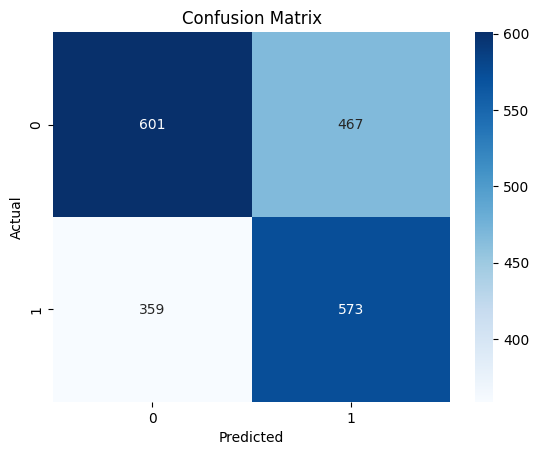

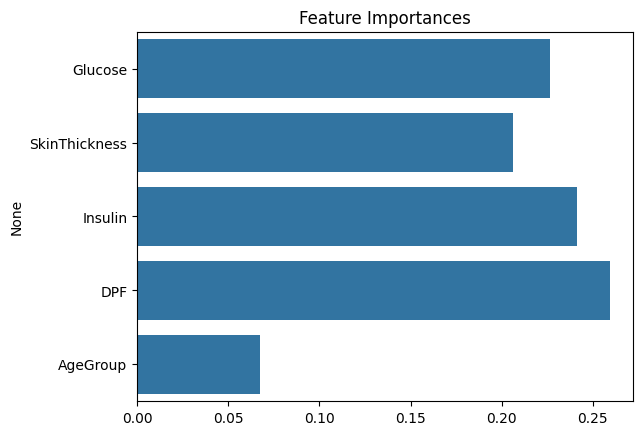

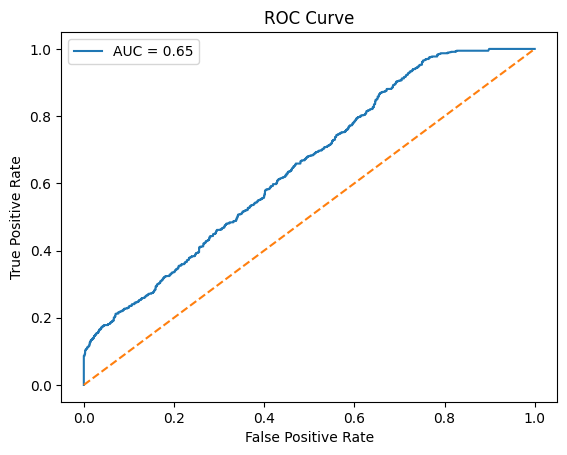

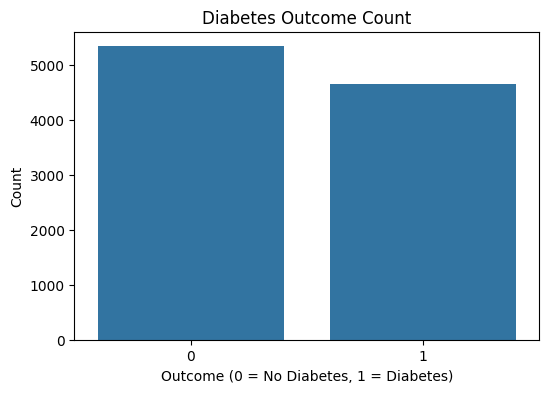

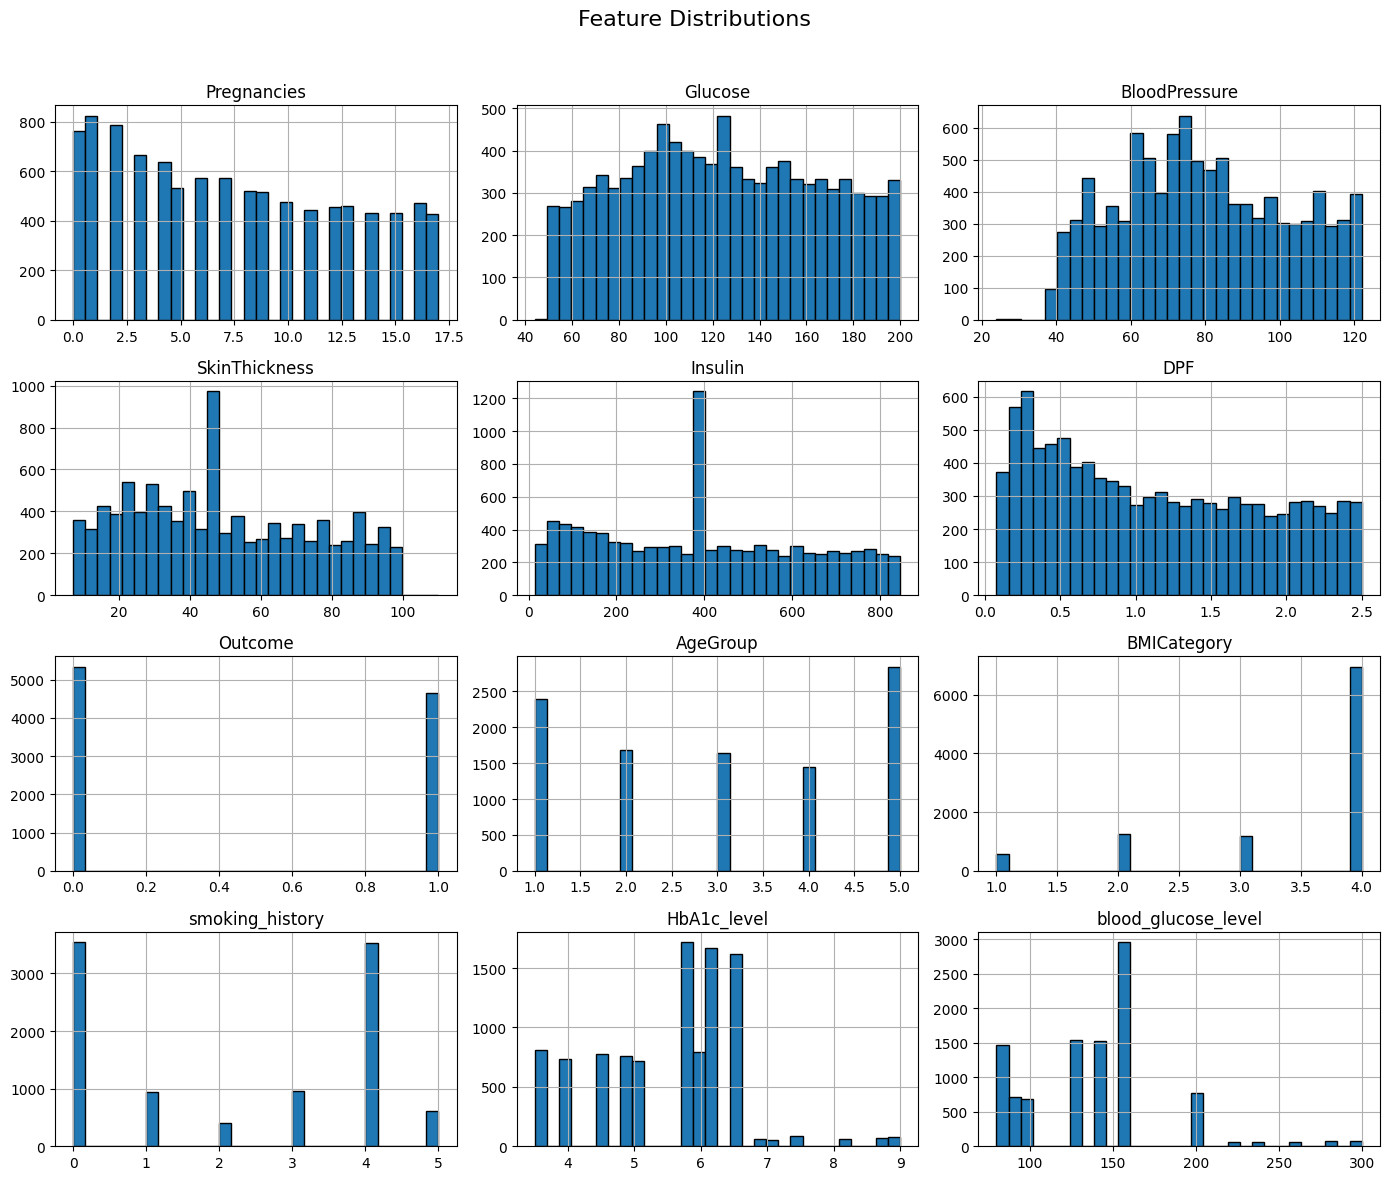

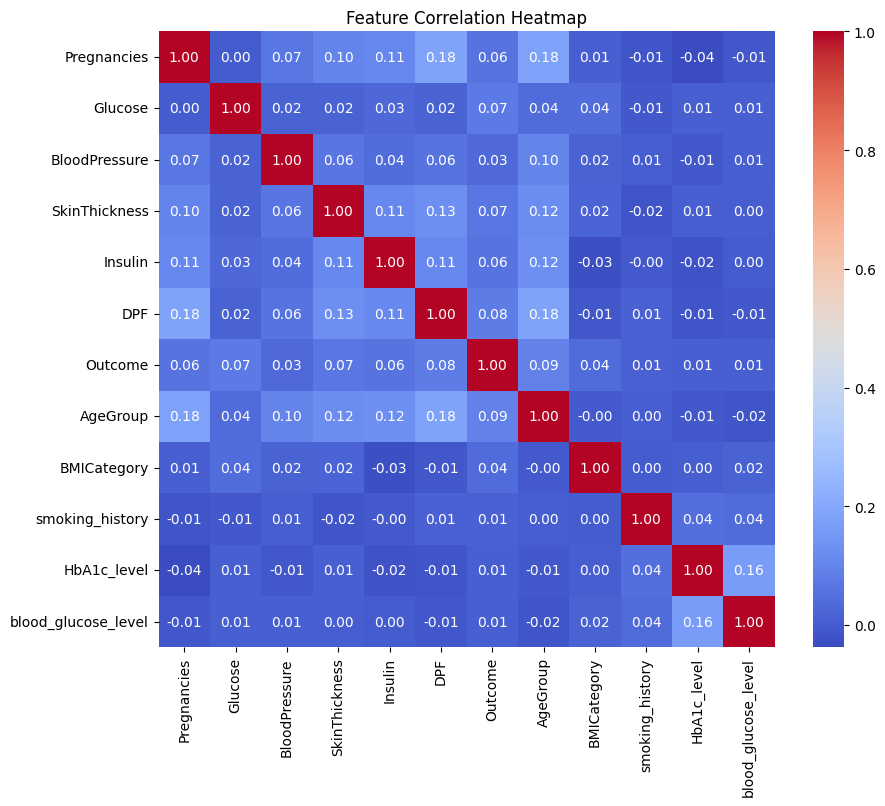

In [10]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feat_names = X.columns[selector.get_support()]
    sns.barplot(x=importances, y=feat_names)
    plt.title('Feature Importances')
    plt.show()

fpr, tpr, _ = roc_curve(y_test, final_model.predict_proba(X_test_selected)[:,1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, final_model.predict_proba(X_test_selected)[:,1]):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
# Visualizing the distribution of the target variable (Outcome)
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Diabetes Outcome Count')
plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
plt.ylabel('Count')
plt.show()

# Histograms of all numerical features
df.hist(figsize=(14, 12), bins=30, edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Correlation heatmap to see relationships between features
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()


## 🧬 SHAP Explanation

ExactExplainer explainer: 101it [00:13,  3.98it/s]                         


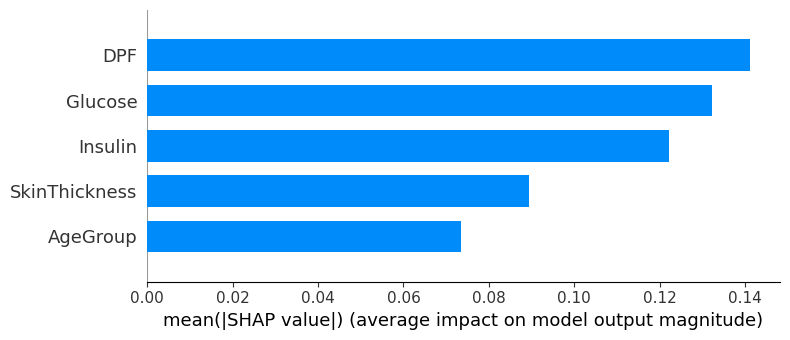

In [11]:
explainer = shap.Explainer(final_model.predict, X_train_selected)
shap_values = explainer(X_train_selected[:100])
shap.summary_plot(shap_values, feature_names=X.columns[selector.get_support()], plot_type='bar')


## 🔍 Diabetes Prediction Function

In [45]:
def predict_diabetes_with_type(pregnancies, glucose, blood_pressure, skin_thickness,
                               insulin, dpf, hba1c, blood_glucose, age_group, bmi_category, smoking_history):
    # Prepare input with correct column names
    features = np.array([[pregnancies, glucose, blood_pressure, skin_thickness,
                          insulin, dpf, hba1c, blood_glucose, age_group, bmi_category, smoking_history]])
    features_df = pd.DataFrame(features, columns=X.columns)
    features_scaled = scaler.transform(features_df)
    features_selected = selector.transform(features_scaled)

    result = final_model.predict(features_selected)[0]
    probs = final_model.predict_proba(features_selected)[0]

    message = ""

    if result == 0:
        message += "✅ Great! You don't have diabetes.\n"
    else:
        # Estimate diabetes type
        if age_group < 2 and bmi_category < 2 and glucose > 130:
            diabetes_type = "Type 1 Diabetes (likely)"
        elif age_group >= 2 and bmi_category >= 2:
            diabetes_type = "Type 2 Diabetes (likely)"


        message += f"⚠️ Oops! You have diabetes.\nEstimated Type: {diabetes_type}\n"

        # Health Tips
        if bmi_category >= 3:
            message += "💡 Tip: Consider a healthy weight loss plan.\n"
        if glucose > 140 or hba1c > 6.5:
            message += "💡 Tip: Monitor your sugar intake.\n"
        if age_group > 3:
            message += "💡 Tip: Regular checkups are highly recommended.\n"

        message += "📅 Suggestion: Please consult a medical professional soon.\n"

    # ✅ Risk Level Evaluation (run for both diabetic and non-diabetic cases)
    risk_score = 0
    if glucose > 150: risk_score += 1
    if bmi_category > 2: risk_score += 1
    if age_group > 3: risk_score += 1

    if risk_score == 0:
        risk_level = "Low Risk"
    elif risk_score == 1:
        risk_level = "Moderate Risk"
    else:
        risk_level = "High Risk"

    message += f"📊 Risk Level: {risk_level}\n"

    if risk_level == "Moderate Risk":
        message += "🔍 Note: You're at moderate risk. It's a good time to adopt healthy habits!\n"
        message += "💡 Tip: Stay active and maintain a balanced diet to reduce future risk.\n"

    return message


In [46]:
test_cases = [
    (2, 130, 70, 20, 85, 0.5, 5.6, 140, 2, 2, 1),
    (6, 180, 80, 35, 150, 1.2, 8.5, 200, 4, 4, 0),
    (4, 110, 75, 22, 90, 0.6, 6.1, 155, 3, 3, 2)
]



for i, case in enumerate(test_cases, 1):
    print(f"\n--- 🔎 Prediction {i} ---")
    print(predict_diabetes_with_type(*case))




--- 🔎 Prediction 1 ---
✅ Great! You don't have diabetes.
📊 Risk Level: Low Risk


--- 🔎 Prediction 2 ---
⚠️ Oops! You have diabetes.
Estimated Type: Type 2 Diabetes (likely)
💡 Tip: Consider a healthy weight loss plan.
💡 Tip: Monitor your sugar intake.
💡 Tip: Regular checkups are highly recommended.
📅 Suggestion: Please consult a medical professional soon.
📊 Risk Level: High Risk


--- 🔎 Prediction 3 ---
✅ Great! You don't have diabetes.
📊 Risk Level: Moderate Risk
🔍 Note: You're at moderate risk. It's a good time to adopt healthy habits!
💡 Tip: Stay active and maintain a balanced diet to reduce future risk.

